In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from efficientnet_pytorch import EfficientNet
#import xgboost as xgb

from skimage.transform import resize
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy.stats import ks_2samp

from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm

In [2]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda


In [4]:
# upload train dataframe
path = "../../data-256/"
test_df = pd.read_csv(path + 'test.csv')
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height
0,ISIC_0052060,IP_3579794,male,70.0,NaN,6000,4000
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,6000,4000
2,ISIC_0058510,IP_7960270,female,55.0,torso,6000,4000
3,ISIC_0073313,IP_6375035,female,50.0,torso,6000,4000
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,1920,1080


In [10]:
# no flip or rotation for test/validation data 
transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).

        # load X
        img_name = self.df['image_name'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)

        # 2. Preprocess the data (e.g. torchvision.Transform)
        img_processed = transform_valid(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed

    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

In [6]:
# Convolutional neural network
class MyENet(nn.Module):
    def __init__(self, ENet):
        super(MyENet, self).__init__()
        # modify output layer of the pre-trained ENet 
        self.ENet = ENet
        num_ftrs = self.ENet._fc.in_features
        self.ENet._fc = nn.Linear(in_features=num_ftrs, out_features=1024)
        # map Enet output to melanoma decision 
        self.output = nn.Sequential(nn.LeakyReLU(),
                                    nn.Dropout(p=0.4),
                                    nn.Linear(1024, 1),
                                    nn.Sigmoid())
        
    def embedding(self, x):
        out = self.ENet(x)
        return out 
        
    def forward(self, x):
        out = self.ENet(x)
        out = self.output(out)
        return out

In [11]:
test_path  = path + "test/"

# define batch size and accumulation steps 
batchsize  = 8

# record out-of-fold predictions and test predictions 
predictions = np.zeros(len(test_df))

# create a test loader 
test_dataset = TestDataset(test_df, test_path)                                              
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batchsize)

# set up model 
ENet = EfficientNet.from_pretrained('efficientnet-b0').to(device)
model = MyENet(ENet).to(device)
model.load_state_dict(torch.load("../Models/model_1.ckpt"))

print("Making predictions on test data...")
test_predictions = []
with torch.no_grad():
    for i, images in enumerate(test_loader):
        images = images.to(device)

        # Forward pass
        outputs = model(images)

        # append predictions
        test_predictions += list(outputs.detach().cpu().numpy())
test_predictions = np.array(test_predictions).ravel()

Loaded pretrained weights for efficientnet-b0
Making predictions on test data...


..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [14]:
image_names = test_df['image_name'].values

submission = pd.DataFrame()
submission["image_name"] = image_names
submission["target"] = test_predictions
submission.to_csv("m1_submission.csv", index=False)

(array([1.0653e+04, 1.4200e+02, 7.2000e+01, 3.7000e+01, 1.7000e+01,
        1.8000e+01, 1.3000e+01, 6.0000e+00, 9.0000e+00, 1.5000e+01]),
 array([7.1873674e-10, 9.9351443e-02, 1.9870289e-01, 2.9805434e-01,
        3.9740577e-01, 4.9675721e-01, 5.9610868e-01, 6.9546008e-01,
        7.9481155e-01, 8.9416295e-01, 9.9351442e-01], dtype=float32),
 <a list of 10 Patch objects>)

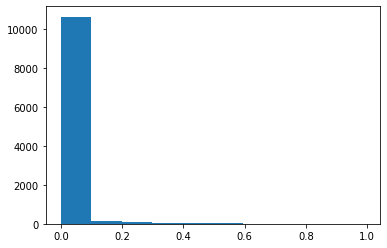

In [23]:
plt.hist(test_predictions)